# CS 591 Melody Detector Project

#### Gabriel Klavans

So I wanted to utilize pitch tracking methods to try to make a function that takes in a song (with a melody) and a melody in the form of a specific sequence of notes (frequencies), and determines whether that melody appears in the song, regardless of key or octave. 

My motivation for abstracting key and octave is that a melody is recognizable in any key and in any octave to due the consistency of the intervalic content of the melody i.e. the ratios between the notes played are the same when transposed by key or octave. Therefore, I decided to attempt to extract this intervalic content from both song and melody and attempt to match some patterns.

In [266]:
# Do some imports and basic definitions/functions
import array as ar
import contextlib
import wave
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Audio

from numpy import arange,linspace,mean, var, std, corrcoef, cov, transpose, ones,log,pi, sin, cos, exp, abs, angle, convolve
from numpy.random import random, randint, uniform
from scipy import signal
from scipy.interpolate import interp1d
from scipy import optimize
from scipy.interpolate import UnivariateSpline

%matplotlib inline

# Basic parameters for reading and writing mono wave files

numChannels   = 1                      # mono
sampleWidth   = 2                      # in bytes, a 16-bit short
SR            = 44100                  #  sample rate
MAX_AMP       = (2**(8*sampleWidth - 1) - 1)    #maximum amplitude is 2**15 - 1  = 32767
MIN_AMP       = -(2**(8*sampleWidth - 1))       #min amp is -2**15

# Read a mono wave file from a local file and return the entire file as a 1-D numpy array
def readWaveFile(infile,withParams=False,asNumpy=True):
    with contextlib.closing(wave.open(infile)) as f:
        params = f.getparams()
        frames = f.readframes(params[3])
        if(params[0] != 1):
            print("Warning in reading file: must be a mono file!")
        if(params[1] != 2):
            print("Warning in reading file: must be 16-bit sample type!")
        if(params[2] != 44100):
            print("Warning in reading file: must be 44100 sample rate!")
    if asNumpy:
        X = ar.array('h', frames)
        X = np.array(X,dtype='int16')
    else:  
        X = array.array('h', frames)
    if withParams:
        return X,params
    else:
        return X

# display a signal in a nice chart
def displaySignal(X, left = 0, right = -1, minAmp=-1.2, maxAmp=1.2,title='Signal Window for X',signalRelative=False,xUnits = "Seconds", yUnits = "Relative",width=12, height=4):
    
    if(signalRelative):
        X = [x*MAX_AMP for x in X]
    minAmplitude = -(2**15 + 100)        # just to improve visibility of curve
    maxAmplitude = 2**15 + 300    
    
    if(xUnits == "Samples"):
        if(right == -1):
            right = len(X)
        T = range(left,right)
        Y = X[left:right]
    elif(xUnits == "Seconds"):
        if(right == -1):
            right = len(X)/44100
        T = np.arange(left, right, 1/44100)
        leftSampleNum = int(left*44100)
        Y = X[leftSampleNum:(leftSampleNum + len(T))]
    elif(xUnits == "Milliseconds"):
        if(right == -1):
            right = len(X)/44.1
        T = np.arange(left, right, 1/44.1)
        leftSampleNum = int(left*44.1)
        Y = X[leftSampleNum:(leftSampleNum + len(T))]
    else:
        print("Illegal value for xUnits")
        
    if(yUnits == "Relative"):
        minAmplitude = minAmp            # just to improve visibility of curve
        maxAmplitude = maxAmp
        Y = [x/32767 for x in Y]

    fig = plt.figure(figsize=(width,height))   # Set x and y dimensions of window: may need to redo for your display
    fig.suptitle(title, fontsize=14, fontweight='bold')
    ax = plt.axes()
    if(xUnits=="Samples"):
        ax.set_xlabel("Sample Number")
    else:
        ax.set_xlabel(xUnits)
    ax.set_ylabel(yUnits + ' Amplitude')
    ax.set_ylim([minAmplitude,maxAmplitude])
    ax.set_xlim([left, right])
    plt.axhline(0, color='black')      # draw the 0 line in black
    plt.plot(T,Y) 
    if(    (xUnits == "Samples" and (right - left) < 101)
        or (xUnits == "Seconds" and (right - left) < 0.001)
        or (xUnits == "Milliseconds" and (right - left) < 1) ):
            plt.plot(T,Y, 'ro')                     
    plt.grid(True)                     # if you want dotted grid lines
    plt.show()

# The Melody Detector

My plan is to use extract a plot of the prominent frequencies in a recording and then use that for detecting melodies. The intervalic movement between two notes is defined by the ratio of the second note to the first. Once we have the pitch plot, we must find the points at which each note transitions to the next, and then find the ratio between the notes after and before each transition point. With this information, we can construct what I call an interval-vector, which we can scan through with the interval vector of the melody we want to find. We can find the vector of the melody much easier, as we already know the separate frequencies in sequence, which we can use to generate the melody interval-vector.

But first, we need to pitch track for the pitch plot.

## Pitch-Track Method 1: Peak-Picking in Frequency Domain

I started off with my intuition that the most prominent note in a signal (in a given window) would be represented by the highest amplitude frequency component generated by the FFT. So I figured I could just use a sliding window to generate spectra for each muically relevant moment (going by at 1/10 a second, as per convention in class) and then pick the max frequency in that moment to be the "melodic note" being played at that moment.

In [267]:
# bring in some functions from the homeworks

notenames = ['A0', 'Bb0', 'B0', 'C1', 'C#1', 'D1', 'Eb1', 'E1', 'F1', 'F#1',
       'G1', 'Ab1', 'A1', 'Bb1', 'B1', 'C2', 'C#2', 'D2', 'Eb2', 'E2',
       'F2', 'F#2', 'G2', 'Ab2', 'A2', 'Bb2', 'B2', 'C3', 'C#3', 'D3',
       'Eb3', 'E3', 'F3', 'F#3', 'G3', 'Ab3', 'A3', 'Bb3', 'B3', 'C4',
       'C#4', 'D4', 'Eb4', 'E4', 'F4', 'F#4', 'G4', 'Ab4', 'A4', 'Bb4',
       'B4', 'C5', 'C#5', 'D5', 'Eb5', 'E5', 'F5', 'F#5', 'G5', 'Ab5',
       'A5', 'Bb5', 'B5', 'C6', 'C#6', 'D6', 'Eb6', 'E6', 'F6', 'F#6',
       'G6', 'Ab6', 'A6', 'Bb6', 'B6', 'C7', 'C#7', 'D7', 'Eb7', 'E7',
       'F7', 'F#7', 'G7', 'Ab7', 'A7', 'Bb7', 'B7', 'C8', 'R']

# Create chromatic scale, e.g., as on the piano, as a dictionary    

Freqs = {} 

f = 27.5

for name in notenames:
    Freqs[name] = f
    f *= 2**(1/12)

Freqs['R'] = 0

# returns real representation of FFT
def realFFT(X):
    return 2*abs(np.fft.rfft(X))/len(X)

# returns real fft as well as amplitude and phase nicely bundled up
def spectrumFFT(X):
    R = np.fft.rfft(X)
    return [ ( k*SR/len(X), 2.0 * np.absolute(R[k])/len(X),np.angle(R[k])+(np.pi/2) ) for k in range(len(R)) ]

# find peaks in a signal with an absolute threshold cutoff
def findPeaksThreshold(A,threshold):      
    peaks = []
    for i in range (1,len(A)-1):
        if A[i-1] < A[i] and A[i+1] < A[i] and A[i] >= threshold:
            peaks.append((i,A[i]))
    return peaks

def parabolicInterpolationPeak(xs,ys):
#     print(xs,ys)
    [x1, x2, x3 ] = xs
    [y1, y2, y3 ] = ys
    denom = (x1 - x2) * (x1 - x3) * (x2 - x3)
    A     = (x3 * (y2 - y1) + x2 * (y1 - y3) + x1 * (y3 - y2)) / denom
    B     = (x3*x3 * (y1 - y2) + x2*x2 * (y3 - y1) + x1*x1 * (y2 - y3)) / denom
    f = interp1d(xs,ys,kind='quadratic')
    x = -B / (2*A)
    return  (x,f(x))

I'll walk through the process using a recording I found online of someone playing the C major scale on a piano.

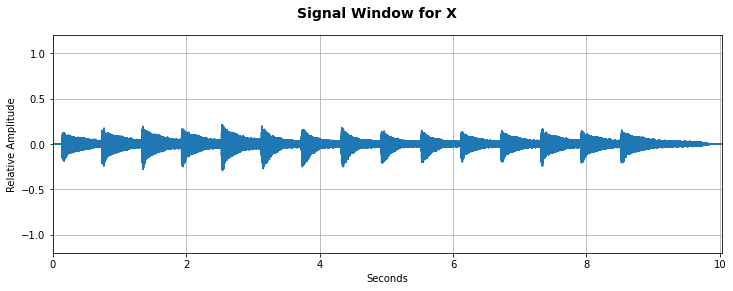

In [268]:
song = readWaveFile("cmaj.wav")

displaySignal(song)
Audio(song, rate=SR)

### i. Get the frequencies

First things first, we gotta slide a window accross the signal to get a spectrum for each moment, and then pick the present frequency with the highest amplitude.

The list of frequencies generated by the raw FFT are not granular enough. Thus, we will interpolate across the points surrounding the max point to get a much closer approximation (my original code interpolated across the whole spectrum then used scipy to get the roots of the derivative, which could then be used to find all the minima and maxima of the frequency graph. But the method in class seems much more efficient).

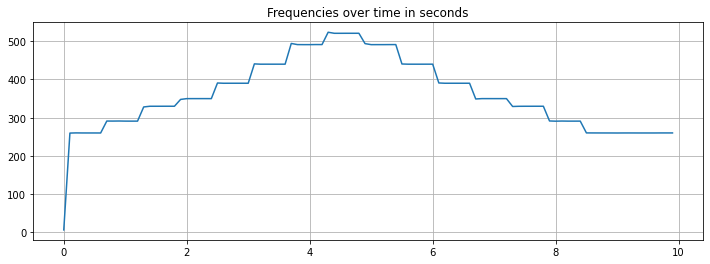

In [269]:
window_size = SR//10

# My old way
# while i < len(cmaj)-window_size:
#     t.append(i)
#     spectrum = spectrumFFT(cmaj[i:i+window_size])
#     freqs = [comp[0] for comp in spectrum]
#     amps = [comp[1] for comp in spectrum]
#     spl = InterpolatedUnivariateSpline(freqs, amps, k=4)
#     minima_maxima = spl.derivative().roots()
#     vals = spl(minima_maxima) # find values of func at min/maxima
    
#     # append the largest local max
#     loudestFreqs.append(minima_maxima[np.argmax(vals)])
#     # we are appending the index of the max, 
#     # which is the frequency of the highest amplitude
    
#     i += window_size

def get_pitch_plot(song, window_size=SR//10, display=True):
    i = 0
    t = []
    pitch_plot = []
    
    while i < len(song)-window_size:
        t.append(i)
        spectrum = spectrumFFT(song[i:i+window_size])
        freqs = [comp[0] for comp in spectrum]
        amps = [comp[1] for comp in spectrum]
        max_point = np.argmax(amps)
    
        # don't wannt loop around in the freqs list if there's a 0 detected
        if (max_point == 0):
            pitch_plot.append(0)
        else:
            (max_freq, max_amps) = parabolicInterpolationPeak([freqs[max_point-1], freqs[max_point], freqs[max_point+1]], [amps[max_point-1], amps[max_point], amps[max_point+1]])
            pitch_plot.append(max_freq)
    
        i += window_size
        
    t = [x/SR for x in t] # convert from samples to time

    if display:
        plt.figure(figsize=(12,4))
        plt.title("Frequencies over time in seconds")
        plt.plot(t, pitch_plot)
        plt.grid()
        plt.show()
        
    return pitch_plot

pitch_plot = get_pitch_plot(song)


### ii. Detect changes in frequnecy

Next, to detect note changes, I graph the derivative of the plot, as the notes are stable when played and change basically instantly when a new note is played. 

NOTE: I stop using time on the x-axis for the plots here and just use the amount of windows sampled. The important part I think is the shape, anyway.

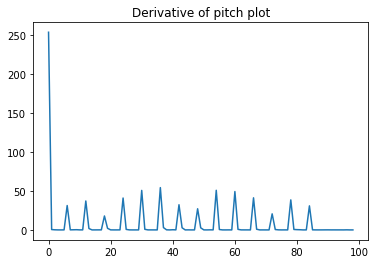

In [270]:
def get_derivative_of_pitch_plot(pp, display=True):

    deriv = np.abs(np.diff(pp))
    
    if display:
        plt.plot(deriv)
        plt.title("Derivative of pitch plot")
        plt.show()
        
    return deriv

get_derivative_of_pitch_plot(pitch_plot);

### iii. Determine position of frequency changes

Next, I find all the peaks of the derivative plot with an absolute threshold. The threshold is there to filter out derivatives from noise and note instability. I decided on the threshold to be the difference from $A_1$ to $A\#_1$, so any change in detected frequency below this differnce ($\approx 3 Hz$) is ignored. I wanted to go down to $A_0$ but I started getting some innacurate readings, so I'll settle for now.

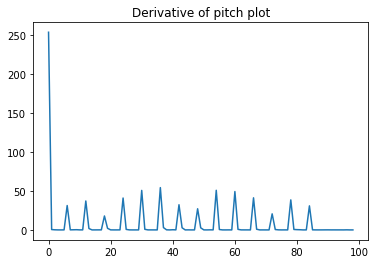

Change-in-frequency threshold: 3.270470189761241 Hz


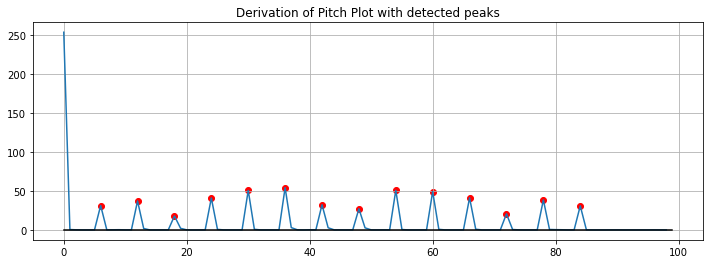

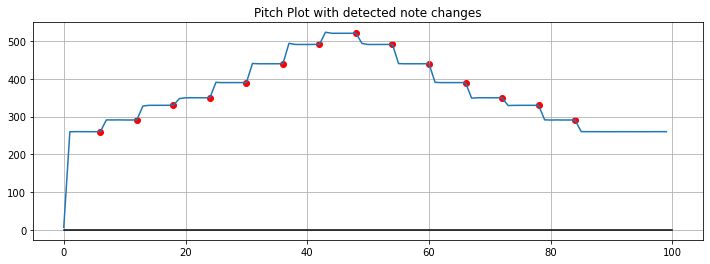

In [271]:
def get_note_transitions(pitch_plot, display=True):
    threshold = Freqs["Bb1"] - Freqs["A1"]
    
    deriv = get_derivative_of_pitch_plot(pitch_plot, display=display
                                        )
    peaks = findPeaksThreshold(deriv, threshold)

    if display:
        print("Change-in-frequency threshold:",threshold,"Hz")
        
        plt.figure(figsize=(12,4))
        plt.title("Derivation of Pitch Plot with detected peaks")
        plt.plot(deriv)
        plt.scatter([peak[0] for peak in peaks],[peak[1] for peak in peaks],color='r')
        plt.plot([0,len(deriv)],[0,0],color='k')
        plt.grid()
        plt.show()

        plt.figure(figsize=(12,4))
        plt.title("Pitch Plot with detected note changes")
        plt.plot(pitch_plot)
        plt.scatter([peak[0] for peak in peaks],[pitch_plot[peak[0]] for peak in peaks],color='r')
        plt.plot([0,len(pitch_plot)],[0,0],color='k')
        plt.grid()
        plt.show()
        
    return peaks

peaks = get_note_transitions(pitch_plot)

### iv. Create intevral vector for song

Next up is to create an **interval vector** using the pitch plot and the detected note transitions. To achieve this, I just take the frequency value 2 window samples before and after each peak, then find the ratio between them to get the intervalic content between each note.

In [272]:
def get_interval_vector(pitch_plot, transitions):
    iv = []
    
    for transition in transitions:
        pre = pitch_plot[transition[0]-2]
        post = pitch_plot[transition[0]+2]
        iv.append(post/pre)
        
    return iv

song_vector = get_interval_vector(pitch_plot, peaks)
# print("Interval Vector:")
print(song_vector)

[1.1195379555373774, 1.1334173727221089, 1.060281197914001, 1.1147410441538137, 1.1276841036205538, 1.116445728644037, 1.0603838301740562, 0.9429225513198712, 0.8958958663196706, 0.8866960101368454, 0.896959678838838, 0.9426774402645426, 0.881763933762571, 0.8939183113415455]


In [273]:
print("Half step up:",2**(1/12))
print("Whole step up:",(2**(1/12))**2)
print("Half step down:",1/(2**(1/12)))
print("Whole step down:",1/((2**(1/12))**2))

Half step up: 1.0594630943592953
Whole step up: 1.122462048309373
Half step down: 0.9438743126816934
Whole step down: 0.8908987181403393


We can see from the above samples that the calculated ratios are pretty close to what they should be. Note (pun intended) that every note in this recording is either a half or whole step away from the next note (as is the case for any major scale)

### v. Create interval vector for melody

Now all we need is a function to generate an interval vector for a specific melody to find, and then we can do a simple comparison!

In [274]:
# I call it a melody vector here for clarity's sake
# Input is a list of strings representing note values
# e.g. ["C5", "G4", "F4", "D5", "C5"]
def get_melody_vector(notes):
    intervals = []
    for i in range(len(notes)-1):
        intervals.append(Freqs[notes[i+1]]/Freqs[notes[i]])
        
    return intervals

melody_vector = get_melody_vector(["D4", "E4", "F4", "G4"])
print(melody_vector)

[1.122462048309373, 1.0594630943592953, 1.122462048309373]


### vi. Find the melody in the song

With these two vectors, I can just slide through the song and see if theres any point where the whole melody vector is present.

#### Aside: Tolerances
The smallest difference between two ratios is $2^{\frac{2}{12}} - 2^{\frac{1}{12}} \approx 0.06299895$

There might be some better mathematical representation of this but I'll leave it at that.

So the detected ratio must be off by less than this amount to maintain integrity of detection while allowing for some approximation errors.

In the function, I allow for more granularity by having a perameter meant to be a percentage of this difference to act as the tolerance.

In [275]:
# expects lists of ratios as representations of the song and melody

# returns location in list of melody if found,
# -1 if not found
def ratio_finder(song, melody, tolerence=0.9):
    detection_threshold = tolerence * (2**(1/6) - 2**(1/12))
    
    for i in range(len(song)):
        # detect if first interval of melody appears in song at all
        if abs(melody[0] - song[i]) <= detection_threshold:
            # now see if the rest of the melody follows in sequence
            found_difference = False
            for j in range(1,len(melody)):
                if abs(melody[j] - song[i+j]) >= detection_threshold:
                    found_difference = True
                    break # or something
            # if flag wasn't tripped, melody was found
            if not found_difference:
                return i # return location of melody
    # if you got this far, the melody wasn't in there or I messed up
    return -1

melody_location = ratio_finder(song_vector, melody_vector)
print(melody_location)

1


We can combine this discovered index with the note transition locations to get the time in the song that the melody starts.

In [276]:
def get_timestamp_of_melody(melody_location, transitions, window_size=SR//10):

    if melody_location > 0:
        start_loc = transitions[melody_location-1][0]
    
        t = np.array([i*window_size for i in range(len(song))])
        t = t / SR
    
        print("Timestamp of melody:")
        print(t[start_loc],"seconds")
    elif melody_location > -1:
        print("Melody is at beginning of song")
    else:
        print("Melody wasn't found")

get_timestamp_of_melody(melody_location, peaks)

Timestamp of melody:
0.6 seconds


Now lets whip up a nice function that rolls all this into one line

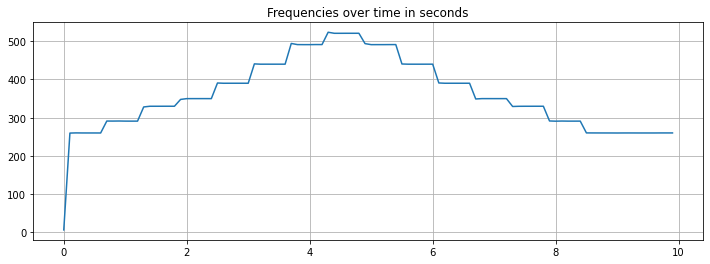

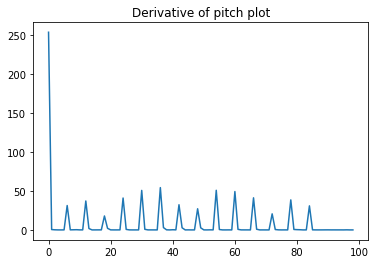

Change-in-frequency threshold: 3.270470189761241 Hz


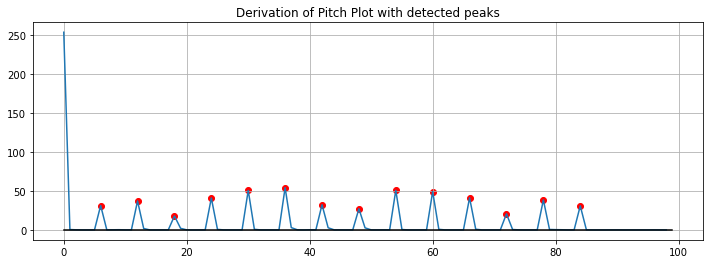

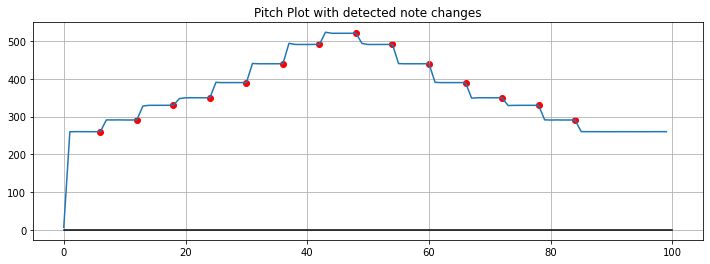

Timestamp of melody:
0.6 seconds


In [277]:
def melody_detector(song, melody, window_size=SR//10, display=True):
    
    pitch_plot = get_pitch_plot(song, window_size=window_size, display=display)
    
    peaks = get_note_transitions(pitch_plot, display=display)
    
    song_vector = get_interval_vector(pitch_plot, peaks)
    
    melody_vector = get_melody_vector(melody)
    
    melody_location = ratio_finder(song_vector, melody_vector)
    
    get_timestamp_of_melody(melody_location, peaks, window_size=window_size)

melody = ["D4", "E4", "F4", "G4"]
melody_detector(song, melody)

#### More examples

Here's a little melody I made myself, it's going up the major scale in thirds. The detector works well here.

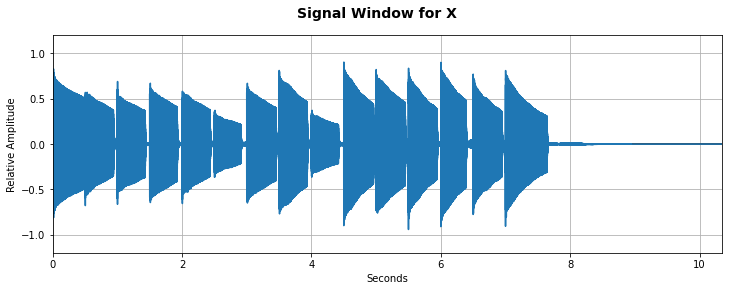

In [278]:
song = readWaveFile("cmaj3rds.wav")

displaySignal(song)
Audio(song, rate=SR)

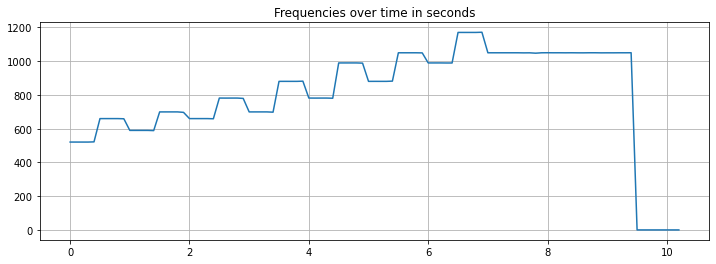

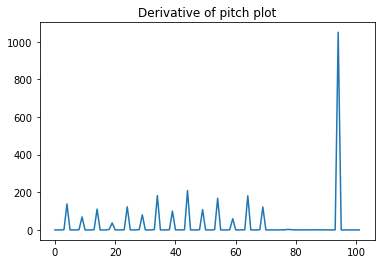

Change-in-frequency threshold: 3.270470189761241 Hz


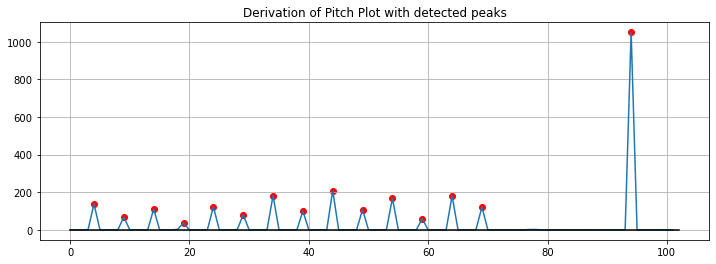

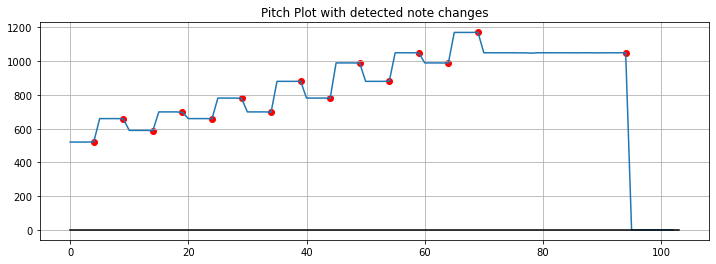

Timestamp of melody:
1.4 seconds


In [279]:
melody = ["F4", "E4", "G4", "F4", "A4"]

melody_detector(song, melody)

### Shortcommings

As it turns out, some instruments will produce harmonics above the fundamental that are slightly higher in amplitude than the fundamental itself! So this method of melody detecing pretty much breaks down if that happens. An example:

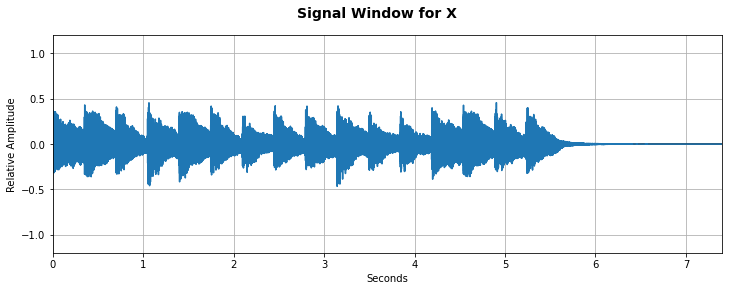

In [280]:
song = readWaveFile("cjam_noback.wav")

displaySignal(song)
Audio(song, rate=SR)

You can see by the 3rd note, the pitch plot jumps up an octave for two notes then jumps back down. The melody that I know is in there was also not found because of this. Not good.

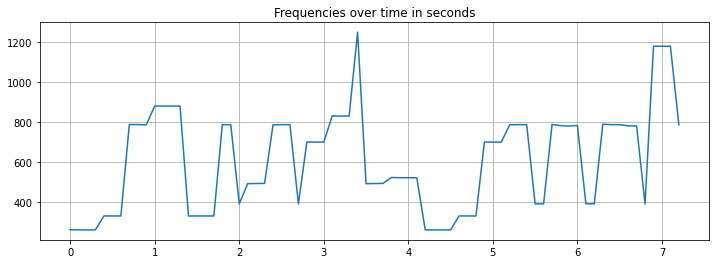

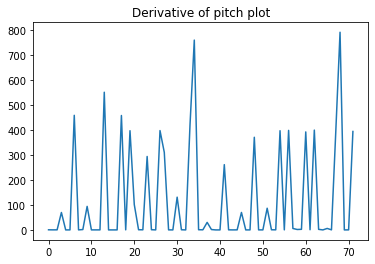

Change-in-frequency threshold: 3.270470189761241 Hz


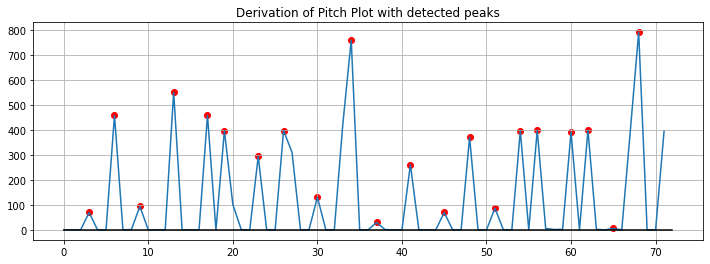

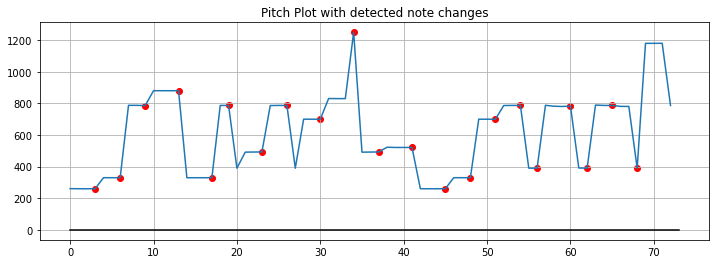

Melody wasn't found


In [281]:
melody = ["E4", "G4", "A4"]
# melody = ["C4", "E4"]

melody_detector(song, melody)

We can also see that a false transition was detected around window sample 65. Must be due to the instability of the pitch coming from the timbre of the piano. I could use a filter to flatten it out a little but that has its own reprecussions that we will look at later.

## Pitch-Track Method 2: Autocorrelation

This method is very clearly better at determining the actual pitch of the note in practice.

In [282]:
# some custom functions

def display_pitch_plot(pitch_plot, overlap, window_size=SR//10, freq_limit=800):
        t = overlap * window_size / SR # for plotting against seconds
        T = np.arange(0,len(pitch_plot)*t,t)
        
        plt.figure(figsize=(12,6))
        freqLimit = 800
        plt.ylim(0,freqLimit)
        # draw note names for C's in all octaves for reference
        C1 = Freqs['C1']
        C4 = Freqs['C4']
        Cs = [ C1 * (2**k) for k in range(8) if (C1*(2**k)) <= freqLimit ]
        for f in Cs:
            plt.plot( [0,T[-1]], [f,f], color='grey', alpha=0.5, linestyle='--' )
        plt.plot( [0,T[-1]], [C4,C4], color='grey' )
        plt.plot(T,pitch_plot)
        plt.grid(axis='x')
        plt.show()

Here I'll import the implementation of pitch tracking using autocorrelation from the homeworks.

In [283]:
# import stuff from homeworks

def corr(X,Y,normalize=True):    
    if normalize:
        X = X / (MAX_AMP/(2**(1/2)))
        Y = Y / (MAX_AMP/(2**(1/2)))
    return (X @ Y) / len(X)

def acorrK(X,k,normalize=True):
    N = len(X)
    return corr(X[:N-k], X[k:], normalize=normalize)

def find_peaks(A,relative_threshold=0.75): 
    absolute_threshold = relative_threshold * max(A)    # or could assume highest value is at A[0]    
    peaks = []
    for t in range(3,len(A)-1):             
        if A[t-1] < A[t] and A[t] > A[t+1] and A[t] > absolute_threshold:
            peaks.append(t)
    return np.array(peaks)

def parabolicInterpolationPeak(xs,ys):
    [x1, x2, x3 ] = xs
    [y1, y2, y3 ] = ys
    denom = (x1 - x2) * (x1 - x3) * (x2 - x3)
    A     = (x3 * (y2 - y1) + x2 * (y1 - y3) + x1 * (y3 - y2)) / denom
    B     = (x3*x3 * (y1 - y2) + x2*x2 * (y3 - y1) + x1*x1 * (y2 - y3)) / denom
    f = interp1d(xs,ys,kind='quadratic')
    x = -B / (2*A)
    return  (x,f(x))

def get_pitch(X,relative_threshold=0.75):
    N = len(X)
    
    # just always normalize
    X = X / (MAX_AMP/(2**(1/2)))
        
    A = []
    peaks = []
    
    for k in range(np.floor(N/2).astype(int)):
        A.append(acorrK(X, k, normalize=False))
        
        peaks = find_peaks(A, relative_threshold=relative_threshold)
        
        if len(peaks) > 0:
            break
    
    # if no peaks were found above the threshold
    if len(peaks) == 0:
        return 0.0
    
    (px, py) = parabolicInterpolationPeak([peaks[0]-1, peaks[0], peaks[0]+1], [A[peaks[0]-1], A[peaks[0]], A[peaks[0]+1]])
        
    return SR/px

def get_pitch_plot(X, window_size=SR//10, overlap=0.5, display=True):
    i = 0
    pitch_plot = []
    while i < (len(X) - window_size):
        f = get_pitch(X[i:i+window_size], relative_threshold=0.75)
        pitch_plot.append(f)
        
        i += int(window_size*(1 - overlap))
        
    if display:
        display_pitch_plot(pitch_plot, overlap)
        
    return pitch_plot

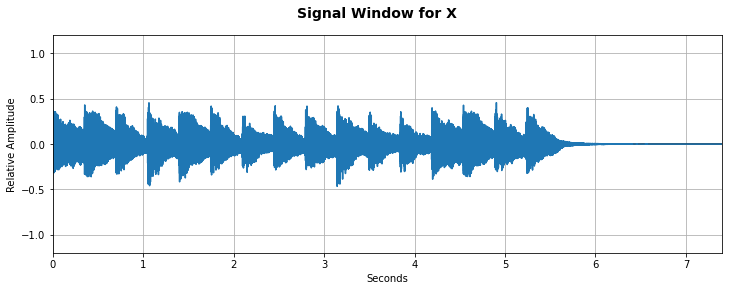

In [284]:
song = readWaveFile("cjam_noback.wav")

displaySignal(song)
Audio(song, rate=SR)

If you look past all the sudden spikes downward, you can see that this plot is much more consistent in its pitch tracking for the same recording.

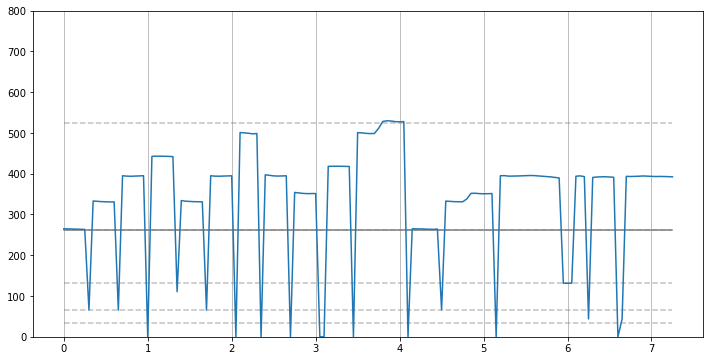

In [285]:
W = SR//10        # window size
L = 0.5         # overlap

pitch_plot = get_pitch_plot(song, W, L)

It might seem intuitive to run a median filter across the plot to smooth out all those downward spikes, and it does work pretty well:

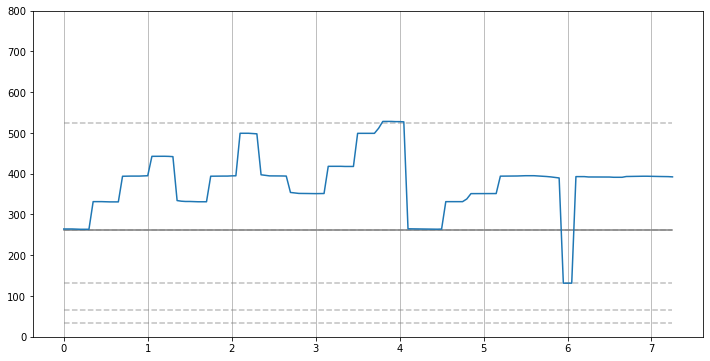

In [286]:
pitch_plot = signal.medfilt(pitch_plot, kernel_size=5) # window size of 5 works for this one


        
display_pitch_plot(pitch_plot, L)

Lets see how it fares when we throw autocorrelation and filtering into the detector.

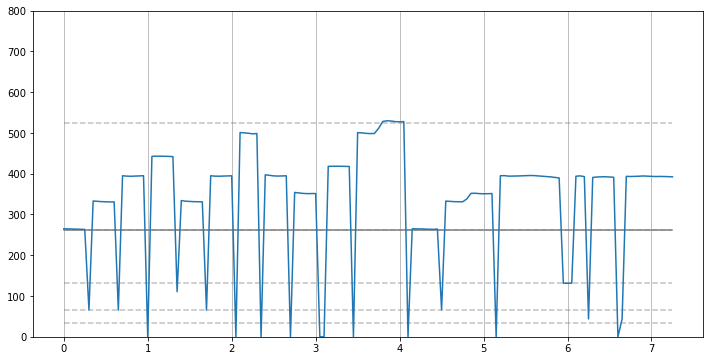

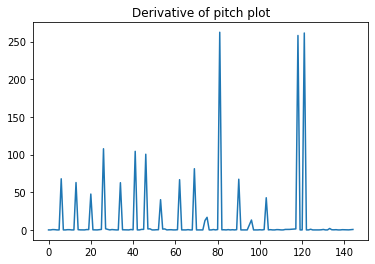

Change-in-frequency threshold: 3.270470189761241 Hz


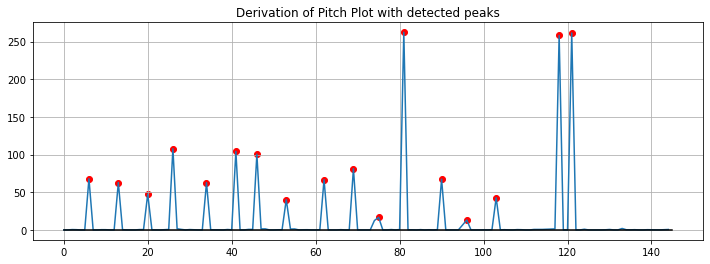

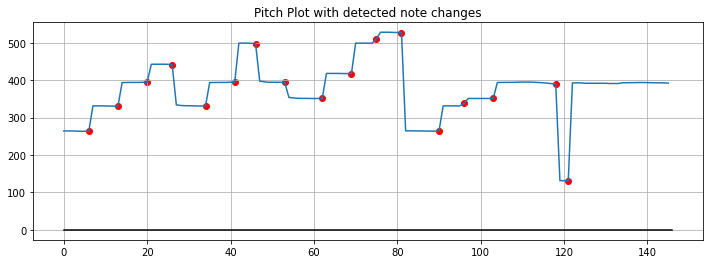

Timestamp of melody:
0.30000000000000004 seconds


In [287]:
# gotta rewrite this to account for overlap
def get_timestamp_of_melody(melody_location, transitions, overlap, window_size=SR//10):

    if melody_location > 0:
        start_loc = transitions[melody_location-1][0]
        
        t = overlap * window_size / SR
        T = np.arange(0,len(pitch_plot)*t,t)
    
        print("Timestamp of melody:")
        print(T[start_loc],"seconds")
    elif melody_location > -1:
        print("Melody is at beginning of song")
    else:
        print("Melody wasn't found")

def melody_detector(song, melody, window_size=SR//10, overlap=0.5, display=True):
    
    pitch_plot = get_pitch_plot(song, window_size=window_size, overlap=overlap, display=display)
    pitch_plot = signal.medfilt(pitch_plot, kernel_size=5)
    
    peaks = get_note_transitions(pitch_plot, display=display)
    
    song_vector = get_interval_vector(pitch_plot, peaks)
    
    melody_vector = get_melody_vector(melody)
    
    melody_location = ratio_finder(song_vector, melody_vector)
    
    get_timestamp_of_melody(melody_location, peaks, window_size=window_size, overlap=overlap)
    
melody = ["E4", "G4", "A4", "E4"]
melody_detector(song, melody)

Below's an example of inputting specific notes and the detector finding a spot that had a sequence with the same intervals between those notes, but that weren't playing those specific notes. I input a melody that wasn't explicitly in the song: $G_4-B_4-C_5$ (M3, m2) and it found $C_4-E_4-F_4$ (M3, m2).

In [288]:
melody = ["G4", "B4", "C5"]
melody_detector(song, melody, display=False)

Timestamp of melody:
4.05 seconds


## Rests

We used a filter to smooth out the pitch plot earlier, but that has the danger of erasing information that is vital to a melody: rests.

If the length of a rest between two notes that are a unison (the same note) is short enough and the window is large enough, a median filter can erase that rest from the pitch plot (a rest would be seen as a sudden drop to 0 in frequency). In the case of these repeated unison notes, the distinction between them would be lost and the algorithm would consider them one long note, which can throw off the detection.

So we scrap the filter here and embrace the 0's as a necessary musical feature.. to deal with...

I will demonstrate with a recording with very short note lengths (I also swung it a little to show rhythm doesn't really matter here)

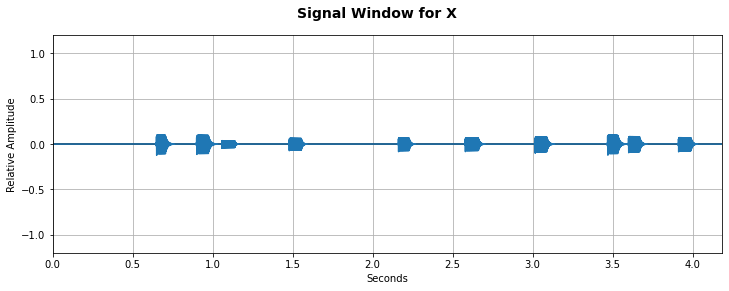

In [289]:
song = readWaveFile("sans.wav")

displaySignal(song)
Audio(song, rate=SR)

Something you'll notice if you run this yourself is that it takes significantly longer to get the plot compared to the other audio samples. Must have something to do with detecing a 0 signal. The speed of this function comes from finding the first peak in the autocorrelation, and if its an empty signal, there won't be a peak and it will have to get the full autocorrelation of every window.

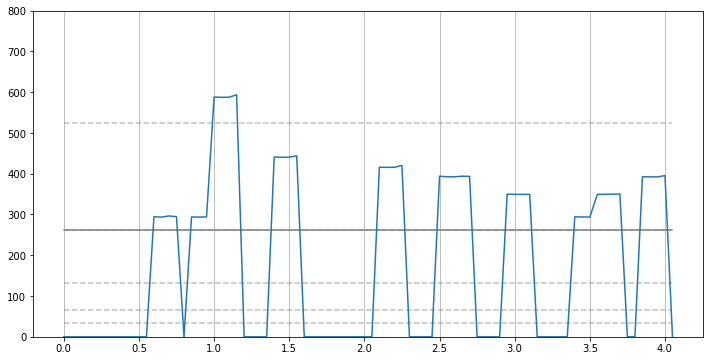

In [290]:
pitch_plot = get_pitch_plot(song)

You can see there's a drop to 0 around 0.75 seconds indicating a vital rest that is clearly present in the melody  if you listen to it. However, this is what happens when we use median smoothing with the smallest possible kernel size:

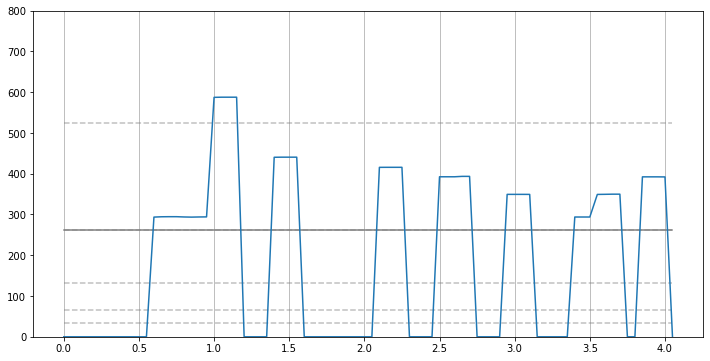

In [291]:
pitch_plot_smoothed = signal.medfilt(pitch_plot, kernel_size=3)

display_pitch_plot(pitch_plot_smoothed, overlap=0.5)

The plateaus for the frequencies are certainly flatter, but that rest is gone. This would be read as a long held out note; that is one one note for the purpose of melody detection, and that's not what we want!

### Accounting for rests in transition detection

So instead, we will rework the ratio calculation algorithm to account for dips to 0.

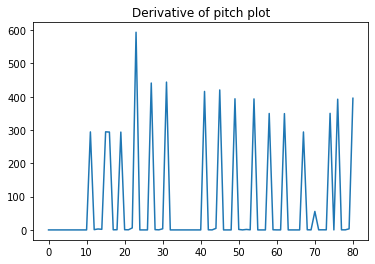

Change-in-frequency threshold: 3.270470189761241 Hz


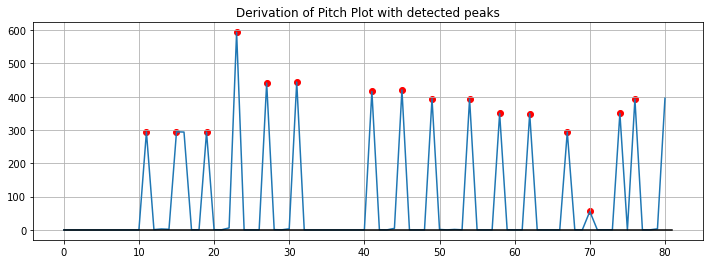

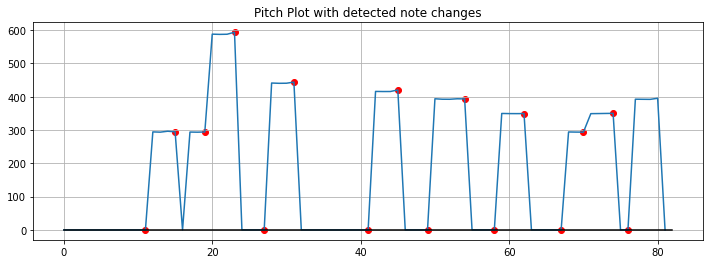

In [292]:
transitions = get_note_transitions(pitch_plot, display=True)

You can see there are now also transitions detected at all of the transitions from silence to notes (that are more than 1 window sample long. If it's only one window sample long then the peak detection can't find it since the absolute value of the derivative is just about constant over those two window samples. Thus, there's only a peak either when the note goes to 0 or when the 0 goes back up. This may sound like it could be an issue, but it won't really, as explained later. This was a very long parenthesis-based aside).

In [293]:
def get_interval_vector(pitch_plot, transitions):
    iv = []

    trans_locations = [transition[0] for transition in transitions]

    pre = pitch_plot[trans_locations[0] - 2]
    post = 0
    # this loop will be from the view point of the first note going to the second note (i is index of first note)
    # thus, there is no need to consider the last 
    for i in range (len(trans_locations)):
        trans = trans_locations[i]
    
        # make sure we aren't starting from a 0
        if pre == 0.0 and i < len(trans_locations) - 1:
            # possible out of bounds
            trans = trans_locations[i+1]
            pre = pitch_plot[trans - 2]
            continue
    
        post = pitch_plot[trans + 2]
        # if post is silence then keep looking for the next note following a peak
        if post == 0.0:
            continue
        else:
            iv.append(post/pre)
            if i == len(trans_locations) - 1:
                # last iteration
                break
            else:
                trans = trans_locations[i+1]
                pre = pitch_plot[trans - 2] 
                
    return iv
                
song_vector = get_interval_vector(pitch_plot, transitions)
print(np.array(song_vector))

[1.00105783 1.9982627  0.749744   0.94389564 0.94434475 0.89028154
 0.8410229  1.1878503  1.12260623]


Going back to that momentary rest, it was effectively skipped over due to reaching 2 units out from the peak for pre/post frequency picking. This shouldn't pose a significant problem, as a peak was still found at the end of the first of the two repeated notes due to there being a drop in frequency at all. In fact, more extended rests are essentially squished to this form using the if statement that checks if post is equal to 0.

The original reason for reaching 2 units out from the peak is that the frequency of the note might not be fully stable so close to the onset of the note. This momentary rest phenomenon may casue a loss of accuracy in the ratio output because we are picking a frequency closer to the onset of a note, due to this skipping effect mentioned. But as long as it works in my testing I'm not super worried about it.

Now I'll bake this new vector generator into the melody detector function 

I actually just replaced the old inner function so all this code block does is remove the filtering step... but it also helps organize my (and hopefully your) thoughts.

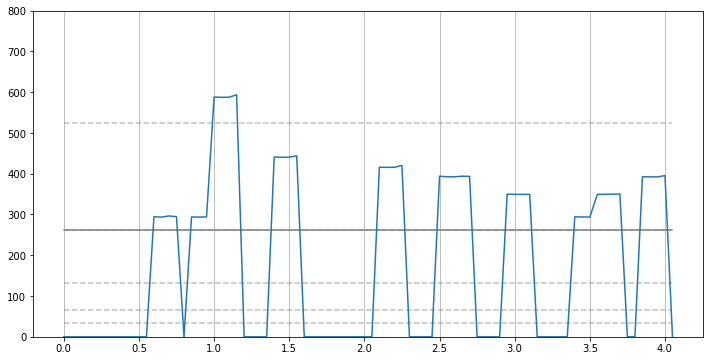

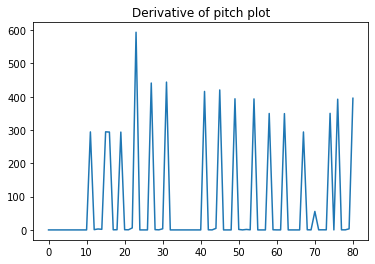

Change-in-frequency threshold: 3.270470189761241 Hz


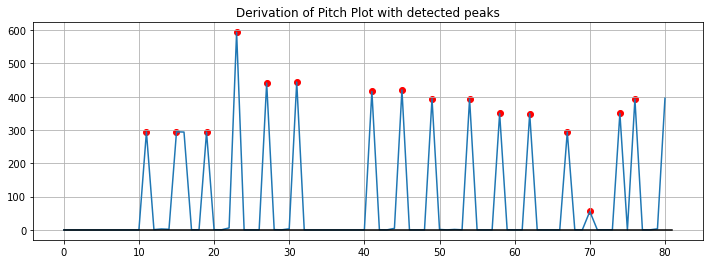

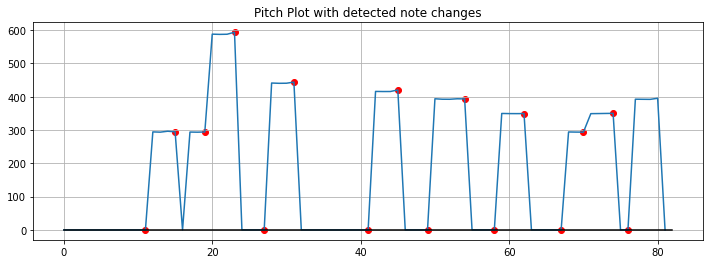

Timestamp of melody:
0.55 seconds


In [294]:
def melody_detector(song, melody, window_size=SR//10, overlap=0.5, display=True):
    
    pitch_plot = get_pitch_plot(song, window_size=window_size, overlap=overlap, display=display)
    
    peaks = get_note_transitions(pitch_plot, display=display)
    
    song_vector = get_interval_vector(pitch_plot, peaks)
    
    melody_vector = get_melody_vector(melody)
    
    melody_location = ratio_finder(song_vector, melody_vector)
    
    get_timestamp_of_melody(melody_location, peaks, window_size=window_size, overlap=overlap)
    
melody = ["D4","D5","A4"]
melody_detector(song, melody)

## Present issues

I've prepared aptly named variations of this audio sample with different note lengths and tempos. It becomes clear that the melody detector falters when two notes of the same frequency are played too quickly, and when notes overlap each other in the melody (which can very much happen in the real world without loss of the sense of sequentialism).

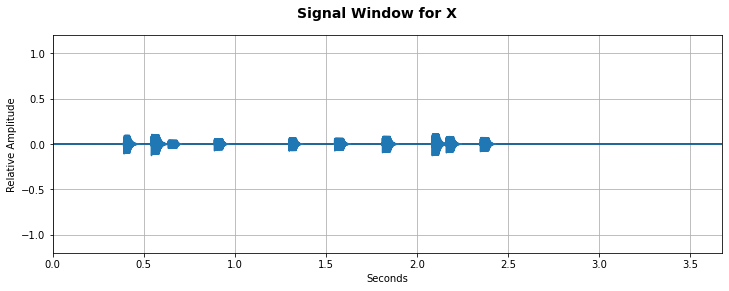

In [295]:
song = readWaveFile("sans_short_fast.wav")
displaySignal(song)
Audio(song, rate=SR)

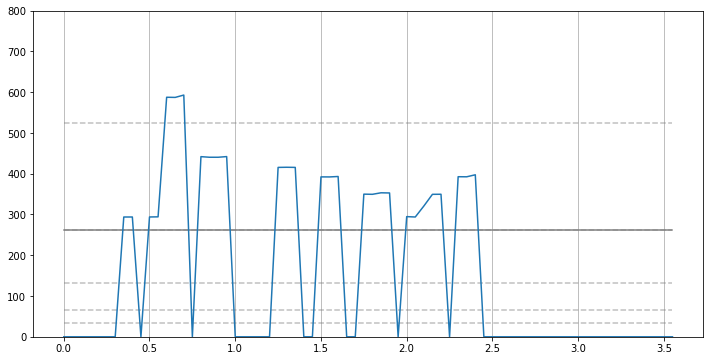

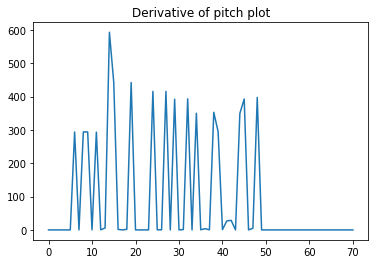

Change-in-frequency threshold: 3.270470189761241 Hz


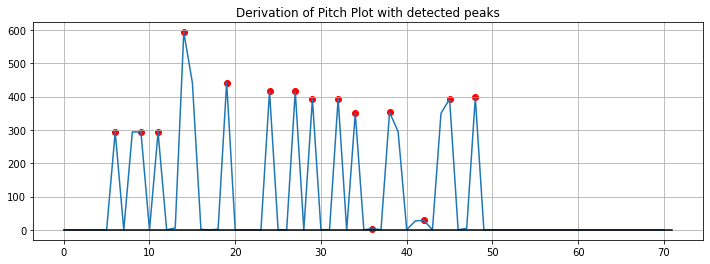

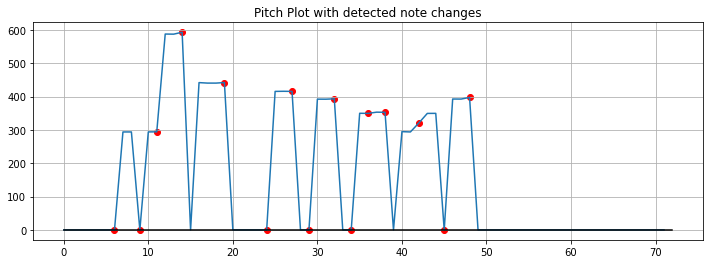

Melody wasn't found


In [296]:
melody = ["D4","D5","A4"]
melody_detector(song, melody)

Here, not only was the melody not found because the pitch detection over-looked the first note sue to its low number of present window samples, but a transition was detected during a moment where the frequency appears to pe increasing linearly... Very strange, and would likely be helped by a smaller window size.

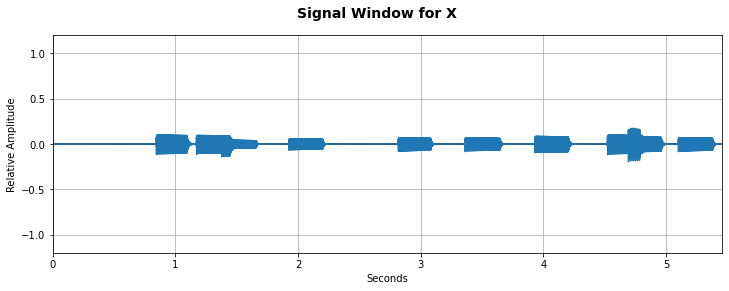

In [297]:
song = readWaveFile("sans_long_slow.wav")
displaySignal(song)
Audio(song, rate=SR)

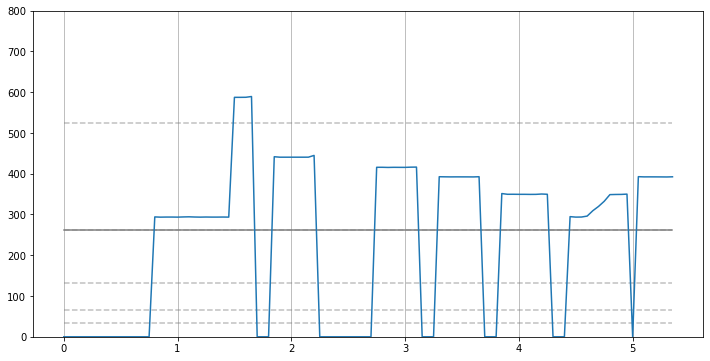

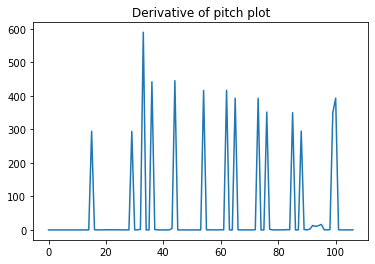

Change-in-frequency threshold: 3.270470189761241 Hz


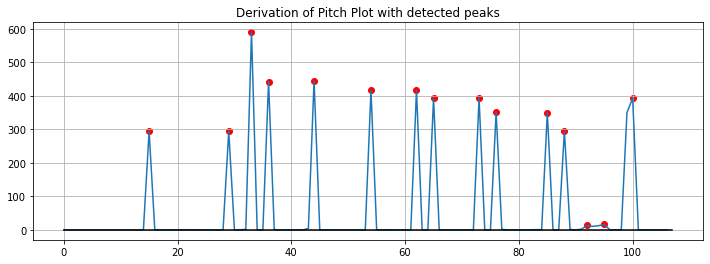

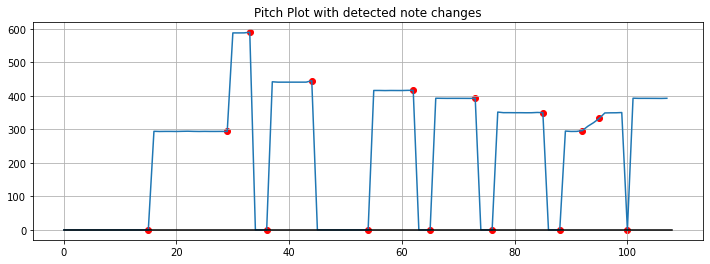

Melody is at beginning of song


In [298]:
melody = ["D4","D5","A4"]
melody_detector(song, melody)

In this case, the rest between the first two notes wasn't even detected in the first place by the pitch track. This could be helped by some onset detection.

Additionally, it seems that "sliding frequency" effect may be cause by two notes being heard at once, from the earlier note ringing into the second. Definitely an issue.

## Further comments

The rest detection method of using 0's seems to work fairly well here, but if we take a look back at this melody played on a piano, the note transitions don't always drop to 0, they drop to some other lower frequency. I can only imagine this is because of the natural decay of harmonics for a piano.

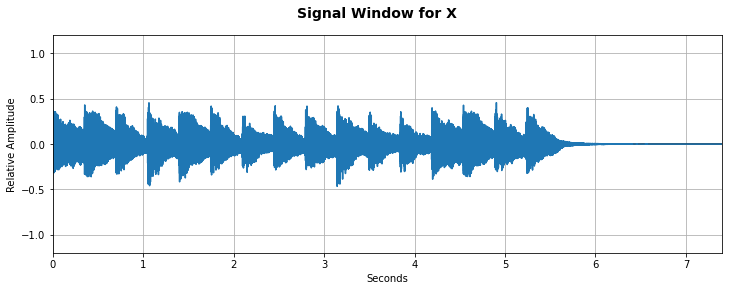

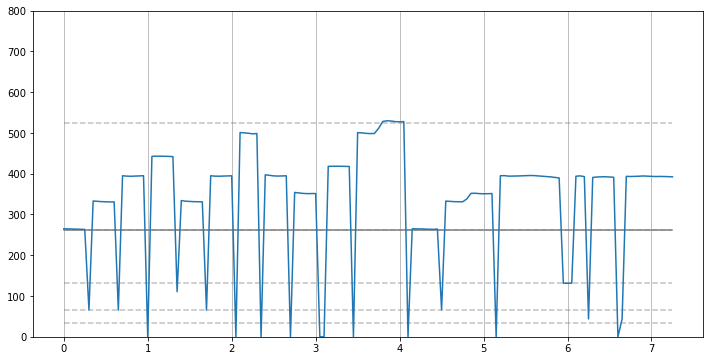

In [299]:
song = readWaveFile("cjam_noback.wav")

displaySignal(song)
get_pitch_plot(song)
Audio(song, rate=SR)

This could cause some unforseen problems with some audio samples.

Additionally, I haven't even gotten to trying to extract a melody out of an audio sample with any other instruments/sounds being played. That would likely pose a whole other host of problems, and is more in line with the issue of selective pitch tracking in general.

# Final remarks

But really, I can't end the project without doing what inspired me to start this project at all... detecting a sneaky lick in an audio sample.

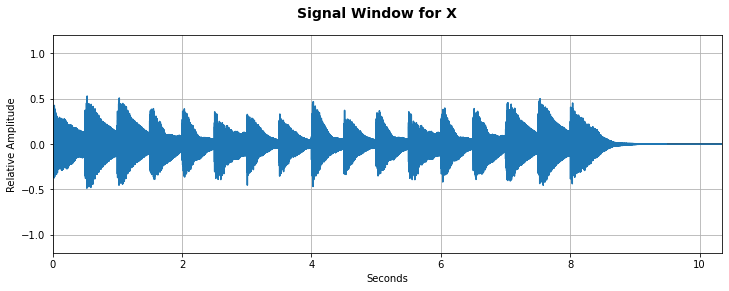

In [300]:
song = readWaveFile("sneacc.wav")
displaySignal(song)
Audio(song, rate=SR)

Here we successfully detect the Lick played in A using the notes for the Lick in Bb. Pretty cool.

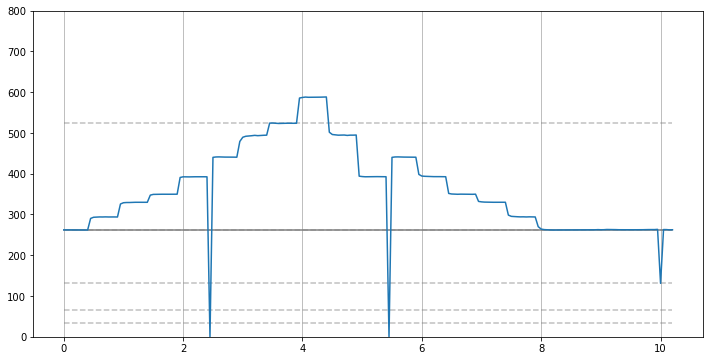

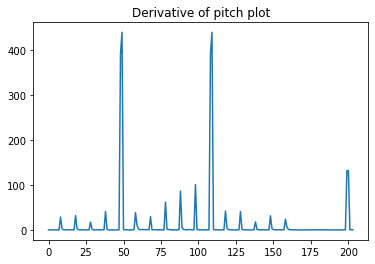

Change-in-frequency threshold: 3.270470189761241 Hz


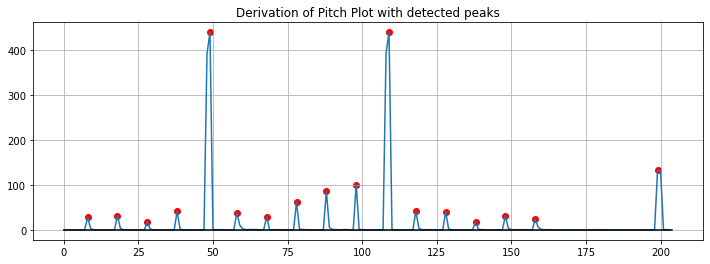

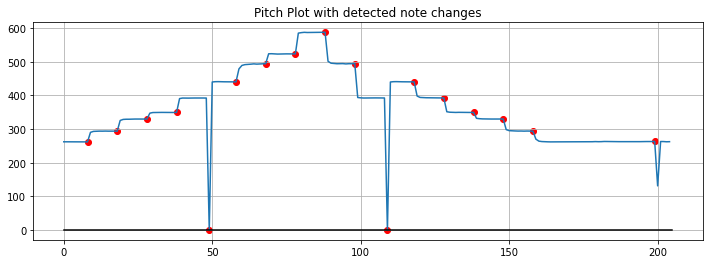

Timestamp of melody:
2.45 seconds


In [301]:
licc_Bb = ["Bb3", "C4", "C#4", "Eb4", "C4", "Ab3", "Bb3"]
melody_detector(song, licc_Bb)